# Explainer notebook for Copenhagen visualizations by Jamie and Valentin

Below is the code and some static graphs used for processing the data used in our project for exploring the city of Copenhagen.
The code is split into the sections that roughly corresponds to the website.

### Motivation
We chose to have a look at the districts of Copenhagen to explore and analyze the difference there are and to see if there were some strong predictors as to whom lives where.
For example: is it only poor people living in Bispebjerg? Are all apartments small in Indre by?

If you want some more info on the why's we made a short video that you can [watch here](https://youtu.be/8-lqqKy7Bio)

N.B. the code will generate files from the relative path "src/data/" so remember to have the whole project folder downloaded to avoid errors.

## Imports, setup and Introduction
We'll import a data set here that is based on peoples age, their sex, income and the district they live in.

We have cleaned the data before importing it and removed unused columns. We have also removed rows with _bad_ values

In [17]:
import os, collections, csv
import pandas as pd, matplotlib as mat, matplotlib.pyplot as plt
import numpy as np
root_directory = os.path.abspath(os.pardir)
df = pd.read_csv(os.path.join(root_directory, "src","data","kon_alder_bydel_penge.csv")) # reads csv

print df.head()
print "\nshape:",df.shape


      Bydel   Køn Aldersgruppe  Personer               Brutto  Kategori
0  Indre By  Mænd       15-19        784          -49.999 kr.         1
1  Indre By  Mænd       15-19        108    50.000-99.999 kr.         2
2  Indre By  Mænd       15-19         33  100.000-149.999 kr.         3
3  Indre By  Mænd       15-19         20  150.000-199.999 kr.         4
4  Indre By  Mænd       15-19          6  200.000-299.999 kr.         5

shape: (705, 6)


Uh, oh. The entries are summed by persons for the categories. Later we'll need the entries to be one individual. Let's repeat on the person count to fix this.

In [18]:
df_repeated = df.loc[df.index.repeat(df['Personer'])].copy().reset_index(drop=True)
df_repeated.drop('Personer', axis=1, inplace=True)

print df_repeated.head()
print "\nshape:",df_repeated.shape

      Bydel   Køn Aldersgruppe       Brutto  Kategori
0  Indre By  Mænd       15-19   -49.999 kr.         1
1  Indre By  Mænd       15-19   -49.999 kr.         1
2  Indre By  Mænd       15-19   -49.999 kr.         1
3  Indre By  Mænd       15-19   -49.999 kr.         1
4  Indre By  Mænd       15-19   -49.999 kr.         1

shape: (473291, 5)


Looks better. We now have $473291$ entries instead of $705$.

Let's take a quick look at the data

In [3]:
# Show number of people in each district
print df.groupby(['Bydel'])['Personer'].sum(),"\n"
print df.groupby(['Aldersgruppe'])['Personer'].sum(),"\n"
print 

Bydel
Amager Vest       52415
Amager Øst        45863
Bispebjerg        44857
Brønshøj-Husum    34166
Indre By          43492
Nørrebro          65847
Valby             41930
Vanløse           32494
Vesterbro         50292
Østerbro          61935
Name: Personer, dtype: int64 

Aldersgruppe
15-19             22421
20-29            132444
30-64            258734
65 og derover     59692
Name: Personer, dtype: int64 




Looks good.
We know that there are many tall buildings on Nørrebro and more villas and Brønshøj-Husum which can contribute to the difference in the population count of the districts. The area of the districts also vary though.

We can see the that the age group _30-64_ years old has the most people in it. It is also the group spanning the most years so it makes sense. Though it is more than three times as _wide_ as the _20-29_ group it has slightly less than two times as many people in it.


## People in age groups listed by districts
Let's try to see the distribution here.
A lot of data processing to calculate the ratio between age groups in different districts.

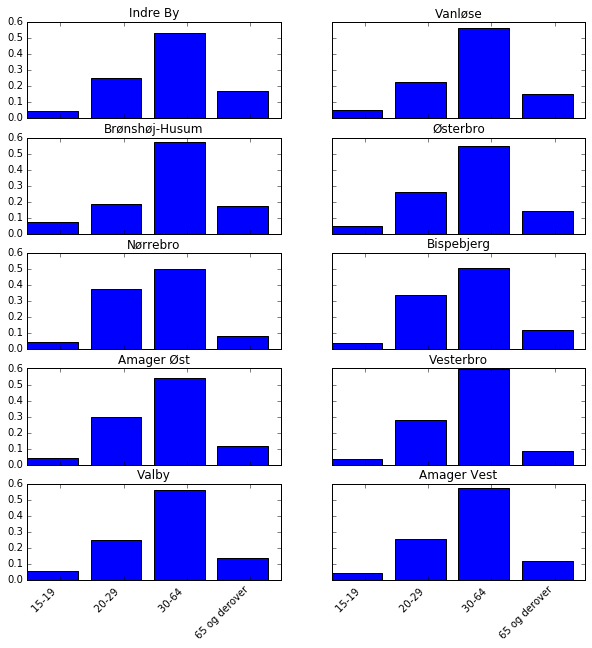

In [4]:
%matplotlib inline
# -*- coding: utf-8 -*-

Districts = df.Bydel.unique()
age_categories = df.Aldersgruppe.unique()

# Total number of people, and people in an age category
total_people = df['Personer'].sum()
people_in_age_category = df.groupby(['Aldersgruppe'])['Personer'].sum().astype(float)

# Create dictionary with ratios
age_category_sum = []
for category in age_categories:
    age_category_sum.append((category, (people_in_age_category[category] / total_people)))
age_category_sum_dict = dict(age_category_sum)


# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
people_in_districts_as_ratio = {}
for district in Districts:
    people_in_districts_as_ratio[district] = {}
    people_in_district = df[df['Bydel'].isin([district])].groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
    total_people_in_district = people_in_district.sum()
    for category in age_categories:
        try:
            people_in_districts_as_ratio[district][category] = (people_in_district[category] / total_people_in_district)
        except KeyError:
            people_in_districts_as_ratio[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(people_in_districts_as_ratio[district].items()))
    axarr[index%5, index%2].set_title(district.decode('utf-8'))
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1
    
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, age_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()



Okay so we can see here that the age group _30-64 years_ is the highest represented (but also the one spanning the most years, except for _65 and above_, unless we take average length of human lives into account).

Furthermore the distribution looks pretty consistent on all the city districts. There are only slight variations visually noticeable.
E.g. _Nørrebro_ has a lot of people in the _20-29 years_ group compared to _Brønshøj-Husum_ which has a lot fewer. Actually the ratio of _20-29 years_ old is twice as high on _Nørrebro_ than it is in _Brønshøj-Husum_.


In [19]:
# We'll just create a file here to plot the ratios on the webpage
data = pd.DataFrame(people_in_districts_as_ratio)
data.to_csv("../src/data/personeriprocent.csv", sep=',', encoding="utf-8")

## Average income by district
We could look at the income by age category as well, but we all probably know how that one will look.

Instead let's take a look at the distribution between the different districts.

This is much like the previous code. Slight alterations have been made to account for the new category we're looking at

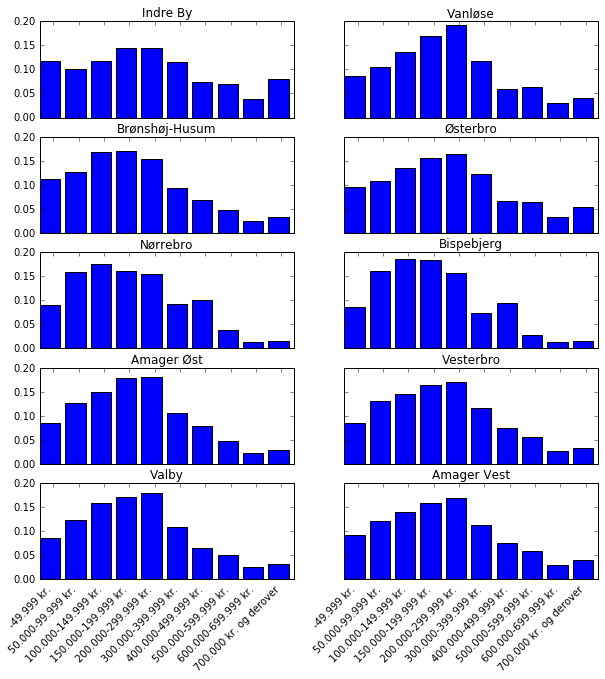

In [6]:
# Create list of categories
income_categories = df.Brutto.unique()

# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
temp = {}
for district in Districts:
    temp[district] = {}
    income_in_district = df[df['Bydel'].isin([district])].groupby(['Brutto'])['Personer'].sum().astype(float)
    total_people_district = income_in_district.sum()
    for category in income_categories:
        try:
            temp[district][category] = income_in_district[category] / total_people_district
        except KeyError:
            temp[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(temp[district].items()))
    axarr[index%5, index%2].set_title(district.decode('utf-8'))
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, income_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()

At a first glance it looks normally distributed with a positive skew for most of the districts.
There is though a huge difference between the wealthiest and the poorest districts. 
Let's try to see the same chart with only the 3 highest income intervals

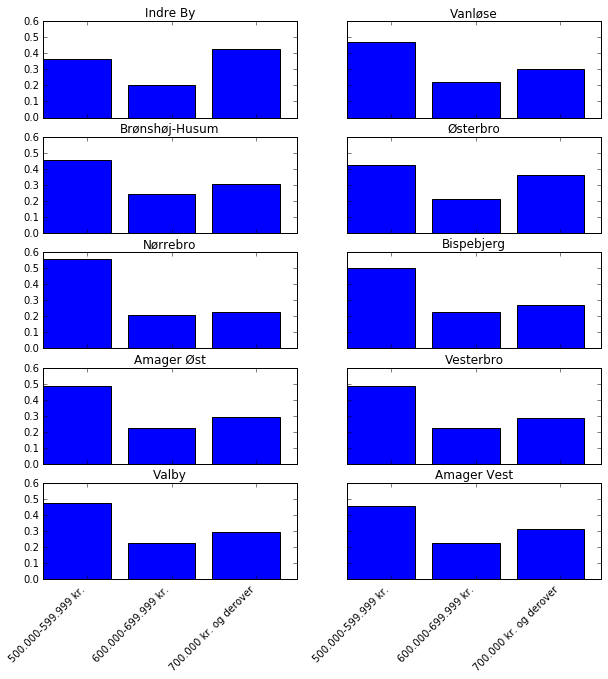

In [7]:
# Create list of categories
income_categories = df.Brutto.unique()[-3:]


# Three subplots sharing both x/y axes
f, axarr = plt.subplots(5,2, sharey=True, sharex=True, figsize=(10,10))

# Loop through districts and calculate ratio of people living in a district by their age category
index = 0
jj = 0
temp = {}
for district in Districts:
    temp[district] = {}
    income_in_district = df[((df.Kategori == 8) 
                   | (df.Kategori == 9)
                   | (df.Kategori == 10))
                   & df['Bydel'].isin([district])].groupby(['Brutto'])['Personer'].sum().astype(float)
    total_people_district = income_in_district.sum()
    for category in income_categories:
        try:
            temp[district][category] = income_in_district[category] / total_people_district
        except KeyError:
            temp[district][category] = 0
    
    d_temp = collections.OrderedDict(sorted(temp[district].items()))
    axarr[index%5, index%2].set_title(district.decode('utf-8'))
    h = axarr[index%5, index%2].bar(range(len(d_temp)), d_temp.values(), color="blue")

    index += 1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.2)
plt.sca(axarr[0, 1])
plt.xticks(rotation=90)
for ax in f.axes:
    mat.pyplot.sca(ax)
    xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
    plt.xticks(xticks_pos, income_categories,  ha='right', rotation=45)

# Show the plots!
plt.show()

## Summing up
Okay let's calculate some descriptive statistics about our population.
We will calculate the mean and median for Copenhagen as well as for the individual districts.
To do this we must first assume that the data is uniformly distributed within our bucket categories.
We use the following formula to calculate the median
$$ L_m + \left [ \frac { \frac{N}{2} - F_{m-1} }{f_m} \right ] \cdot c $$

And to calculate the mean $\mu$ we simply calculate the mean $\mu_2$ of an interval and use that to calculate $\mu$.

According to Danmarks Statistik (DST) the mean income in Copenhagen is $261.882$ DKK, and the mean age is $35,9$ years old

In [8]:
people_sum_income = df.groupby(['Brutto'])['Personer'].sum().astype(float)
people_sum_age = df.groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
#Lm is the lower class boundary of the group containing the median
#n is the total number of values
#Fm_old is the cumulative frequency of the groups before the median group
#Fm is the frequency of the median group
#c is the group width
income_category_list = [
    (0,49999),
    (50000,99999),
    (100000,149999),
    (150000,199999),
    (200000,299999),
    (300000,399999),
    (400000,499999),
    (500000,599999),
    (600000,699999),
    (700000,1000000) # Larger interval here to "capture" more of the incomes above 700.000
]
age_category_list = [
        (15,19),
        (20,29),
        (30,64),
        (65,80) # Interval goes up to average lifespan in Denmark
]

def median(data, category):
    result = 0
    N = data.sum()
    Median_group = N/2
    Lm = 0
    c = 0
    fm = 0
    Fm_old = 0
    cumsum = 0
    index = 0
    for ii in data:
        cumsum = ii + cumsum
        if cumsum >= Median_group: # find the median group so we calculate the median for the right group
            Lm = category[index][0]
            c = category[index][1] - category[index][0]
            fm = ii
            result = Lm + ((N/2 - Fm_old)/fm) * c
            break
        Fm_old = Fm_old + ii
        index = index+1
        
    return result    
        

income_category_mean = [
        (0+49999)/2.0,
        (50000+99999)/2.0,
        (100000+149999)/2.0,
        (150000+199999)/2.0,
        (200000+299999)/2.0,
        (300000+399999)/2.0,
        (400000+499999)/2.0,
        (500000+599999)/2.0,
        (600000+699999)/2.0,
        (700000+300000)/1.0
]
age_category_mean = [
        (15+19)/2.0,
        (20+29)/2.0,
        (30+64)/2.0,
        (65+80)/2.0
]
def mean(data, category):
    people_sum_total = data.sum()
    
    mean_list = [y*x for x,y in zip(category, data.values)]
    mu = (sum(mean_list))/(people_sum_total)
    return mu

print 'Copenhagen'
print '-' * len('Copenhagen')
print 'median income: {0:.0f} DKK'.format(median(people_sum_income, income_category_list))
print 'mean income: {0:.0f} DKK'.format(mean(people_sum_income,income_category_mean))
print 'median age: {0:.2f} years'.format(median(people_sum_age, age_category_list))
print 'mean age: {0:.2f} years'.format(mean(people_sum_age,age_category_mean))



Copenhagen
----------
median income: 188987 DKK
mean income: 255109 DKK
median age: 40.75 years
mean age: 42.50 years


We see that the calculated mean income for Copenhagen is $255.109$ DKK which is only a $2,6\%$ deviation from the statistics from DST.
The situation is a bit different for the mean age, calculated to be $42,5$ years deviates $16,8\%$ from the DST statistics. It is due to the assumption about the data being uniformly distributed and setting the maximum of the last interval to the expected lifespan when we know there are fewer people who are $80$ years old than there are people that are $60$ years old.
There is no data we can hold the calculated medians up against, but they seem reasonable as we might expect extreme values to not have as big an influence on the median.

In [9]:
from prettytable import PrettyTable
my_dict = {}
table = PrettyTable()
# calculate means and medians again for all districts
table.field_names = ["District", "Mean Income", "Median Income", "Mean Age", "Median Age"]
for district in Districts:
    people_sum_age = df[df['Bydel'] == district].groupby(['Aldersgruppe'])['Personer'].sum().astype(float)
    people_sum_income = df[df['Bydel'] == district].groupby(['Brutto'])['Personer'].sum().astype(float)
    my_dict[district] = [
        "{0:.0f}".format(mean(people_sum_income,income_category_mean)),
        "{0:.0f}".format(median(people_sum_income, income_category_list)),
        "{0:.0f}".format(mean(people_sum_age,age_category_mean)),
        "{0:.0f}".format(median(people_sum_age, age_category_list))
    ]
    table.add_row([district, my_dict[district][0], my_dict[district][1], my_dict[district][2], my_dict[district][3]])
       

print table.get_string(sortby="Mean Income")

+----------------+-------------+---------------+----------+------------+
|    District    | Mean Income | Median Income | Mean Age | Median Age |
+----------------+-------------+---------------+----------+------------+
|   Bispebjerg   |    217347   |     168333    |    41    |     38     |
|    Nørrebro    |    226183   |     173703    |    39    |     35     |
| Brønshøj-Husum |    241220   |     177383    |    45    |     44     |
|   Amager Øst   |    246835   |     188885    |    42    |     40     |
|     Valby      |    249359   |     188405    |    43    |     42     |
|   Vesterbro    |    256171   |     193050    |    42    |     40     |
|  Amager Vest   |    265596   |     196465    |    43    |     42     |
|    Vanløse     |    267543   |     202155    |    44    |     43     |
|    Østerbro    |    280601   |     204194    |    43    |     42     |
|    Indre By    |    303568   |     214628    |    44    |     43     |
+----------------+-------------+---------------+---

We can clearly see a difference in the different districts. For example
_Brønshøj_ has the highest mean age at $45,0$ years
_Nørrebro_ has the lowest at $39,3$ years.
_Bispebjerg_ has the lowest mean income and _Indre By_ has the highest with a $33.1\%$ difference.


## Machine learning: Progression or Regression?
We will now look into machine learning to see if it is possible to train models to predict in which district a person lives based on the attributes we have in our dataset

As we will see in the following part.
This dataset is not very well suited for linear or logistic regression.

We will start by plotting the data

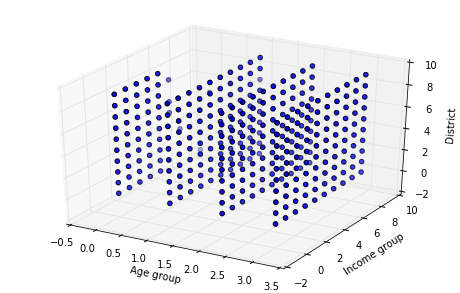

In [10]:
from mpl_toolkits.mplot3d import axes3d
from sklearn import preprocessing

xs = preprocessing.LabelEncoder().fit_transform(df['Aldersgruppe'])
ys = preprocessing.LabelEncoder().fit_transform(df['Kategori'])
zs = preprocessing.LabelEncoder().fit_transform(df['Bydel'])

fig = plt.figure(figsize=(8,5), facecolor='w')
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs)
ax.set_xlabel('Age group')
ax.set_ylabel('Income group')
ax.set_zlabel('District')

plt.show()

It is pretty evident that the data lies in the four age categories, the ten income categories and the 10 city districts.

Let's move on to making a regression model

In [11]:
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, decomposition

target = df['Bydel']
vectorizer = DV( sparse = False )
train_dict = df[['Kategori', 'Aldersgruppe']].T.to_dict().values()
X = vectorizer.fit_transform(train_dict)

logistic = linear_model.LogisticRegression(C=1e5)
maxScore = 0
minScore = 100
for x in range(250):
    X_train, X_test, target_train, target_test = train_test_split( X, target, test_size=0.1)
    logistic.fit(X_train, target_train)
    tmp = logistic.score(X_test, target_test)
    if tmp > maxScore:
        maxScore = tmp
    if tmp < minScore:
        minScore = tmp
print "max score: {0:.2f}%".format(maxScore*100)
print "min score: {0:.2f}%".format(minScore*100)

max score: 5.63%
min score: 0.00%


It is apparent that the model scores very poorly. 
The data is also multi-class instead of binary which makes score a harsh prediction for the logistic regression model.
Running the fit and score function on several splits on the data shows we get a score in the range of $0-7\%$.
Random guessing would give us a mean score of $10\%$ which shows how bad this model is.

To increase the score of the model we will use Principal Component Analysis

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

# target = df_repeated['Bydel']
# train_dict = df_repeated[['Kategori', 'Aldersgruppe', 'Køn']].T.to_dict().values()
# X = vectorizer.fit_transform(train_dict)

# X_train, X_test, target_train, target_test = train_test_split( X, target, test_size=0.1)

# logistic = linear_model.LogisticRegression()

# pca = decomposition.RandomizedPCA()
# pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# pipe.fit(X_train, target_train)

# # Example code from sklearns documentation
# ###############################################################################
# # Plot the PCA spectrum
# pca.fit(X)
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# plt.axes([.2, .2, .7, .7])
# plt.plot(pca.explained_variance_, linewidth=2)
# plt.axis('tight')
# plt.xlabel('n_components')
# plt.ylabel('explained_variance')

# ###############################################################################
# # Prediction

# n_components = [1, 2, 3, 4]
# Cs = np.logspace(-2, 2, 1)

# estimator = GridSearchCV(pipe,
#                          dict(pca__n_components=n_components,
#                               logistic__C=Cs))
# estimator.fit(X_train, target_train)

# plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
#             linestyle=':', label='n_components chosen')
# plt.legend(prop=dict(size=12))
# plt.show()
# print estimator.predict(X_test)
# print "max score: {0:.2f}%".format(estimator.best_score_ * 100)

We're up to a whopping $15-17\%$ now! (Just kidding). That is only slightly better than guessing at random.
Let's see what decision trees can do.

# Decisions, decisions, decisions
Time to look at some decision trees.
As we saw ealier the some features are more representative for a district than others, for expample, income might be an important feature to take into consideration when determining where a person lives, while gender most likely is not.

In order to predict where a person lives, we have chosen four datasets to train our decision tree classifiers, which in addition to being classified per district also contains information on:
* Dataset1 - Age, sex and income
* Dataset2 - Ownership and living space
* Dataset3 - Civil status and number of children
* Dataset4 - Ancestry, education and age

These data sets have no relation to each other, they are produced by individual surveys and some represent features per habitant and others are features per residence.
We can therefore not train a decision tree to take all of this data into account, what we have done instead is to train four seperate decision trees, one for each of the datasets. 

In [20]:
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import tree
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.preprocessing import Imputer
import pydot
from IPython.display import Image

# load in datasets
df_KABP = pd.read_csv(os.path.join(root_directory, "src","data","kon_alder_bydel_penge.csv")) # reads csv
df_KABP_repeated = df_KABP.loc[df_KABP.index.repeat(df_KABP['Personer'])].copy().reset_index(drop=True)

df_BEA = pd.read_csv(os.path.join(root_directory, "src","data","boliger_ejerforhold_areal.csv")) # reads csv
df_BEA_repeated = df_BEA.loc[df_BEA.index.repeat(df_BEA['Antal boliger'])].copy().reset_index(drop=True)

df_AHU = pd.read_csv(os.path.join(root_directory, "src","data","Alder_herkomst_uddanelse.csv")) # reads csv
df_AHU_repeated = df_AHU.loc[df_AHU.index.repeat(df_AHU['Personer'])].copy().reset_index(drop=True)


df_CB = pd.read_csv(os.path.join(root_directory, "src","data","civilstatus_born.csv")) # reads csv
df_CB_repeated = df_CB.loc[df_CB.index.repeat(df_CB['Antal'])].copy().reset_index(drop=True)
def createDT (name, data, target):
    
    vectorizer = DV( sparse = False )
    train_dict = data.T.to_dict().values()
    X = vectorizer.fit_transform(train_dict)
    X_train, X_test, target_train, target_test = train_test_split( X, target, test_size=0.1)

    clf = tree.DecisionTreeClassifier(max_depth=7)
    clf = clf.fit(X_train, target_train)


    print name, "model prediction accuracy score: ", clf.score(X_test, target_test, sample_weight=None)
    return clf, vectorizer, target.unique()
ctf_civil, vec4,  label4 = createDT("civil status and children",df_CB_repeated[['Born', 'Famtype']], df_CB_repeated['Bydel'])
ctf_person, vec2, label2 = createDT("age and income",df_KABP_repeated[['Kategori', 'Aldersgruppe']], df_KABP_repeated['Bydel'])
ctf_person2, vec3, label1  = createDT("education, age and heritage",df_AHU_repeated[['Gruppe', 'Uddannelseskategori', 'Herkomst']], df_AHU_repeated['Bydel'])
ctf_bolig, vec1, label1 = createDT("ownership and living space",df_BEA_repeated[['EJERFORHOLD', 'SAMAREAL']], df_BEA_repeated['Bydel'])

civil status and children model prediction accuracy score:  0.150132640654
age and income model prediction accuracy score:  0.160447918868
education, age and heritage model prediction accuracy score:  0.165076223463
ownership and living space model prediction accuracy score:  0.198928970366


As you can see the four decision trees perform quite similarly, and quite poorly.
There are $10$ dsitricts in Copenhagen so guessing at random, one should have an accuracy of about $0.1$.
But by combining the predictive power of these four trees, one can possibly achieve a better prediction.
Below is a function for combining the predictions of the four trees, aka. forest.

### accumulateProba
accumulates the probalities that each tree has assigned to all the districts and returns the district that is appointed as the most probable district, by the forest.

We made a test dataset of including us both and one _random guy_. To see how well our algorithm performed

In [24]:
test = pd.read_csv(os.path.join(root_directory, "notebooks","mig.csv"))
def accumulateProba(ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, persons):
    mitHjem = persons[['EJERFORHOLD', 'SAMAREAL']].T.to_dict().values()

    mig = persons[['Kategori', 'Aldersgruppe']].T.to_dict().values()

    mereMig = persons[['Gruppe', 'Uddannelseskategori', 'Herkomst']].T.to_dict().values()

    migOgDig = persons[['Born', 'Famtype']].T.to_dict().values()

    X1 = vec1.transform(mitHjem)
    X2 = vec2.transform(mig)
    X3 = vec3.transform(mereMig)
    X4 = vec4.transform(migOgDig)
    answer1 = ctf_bolig.predict_proba(X1)
    answer2 = ctf_person.predict_proba(X2)
    answer3 = ctf_person2.predict_proba(X3)
    answer4 = ctf_civil.predict_proba(X4)
    answers = answer1 + answer2 + answer3 + answer4
    index = [np.argmax(x) for x in answers]
    result = []
    for i in index:
        result.append(ctf_bolig.classes_[i].decode('utf-8'))
    return result
print accumulateProba(ctf_bolig, ctf_person, ctf_person2, ctf_civil, vec1, vec2, vec3, vec4, test)

[u'N\xf8rrebro', u'N\xf8rrebro', u'\xd8sterbro']


Finally we would like to show you the code that we used to export the decision tree classifier to javascript and eventually to our [website](http://valentinibanez.github.io/assignmentB). 

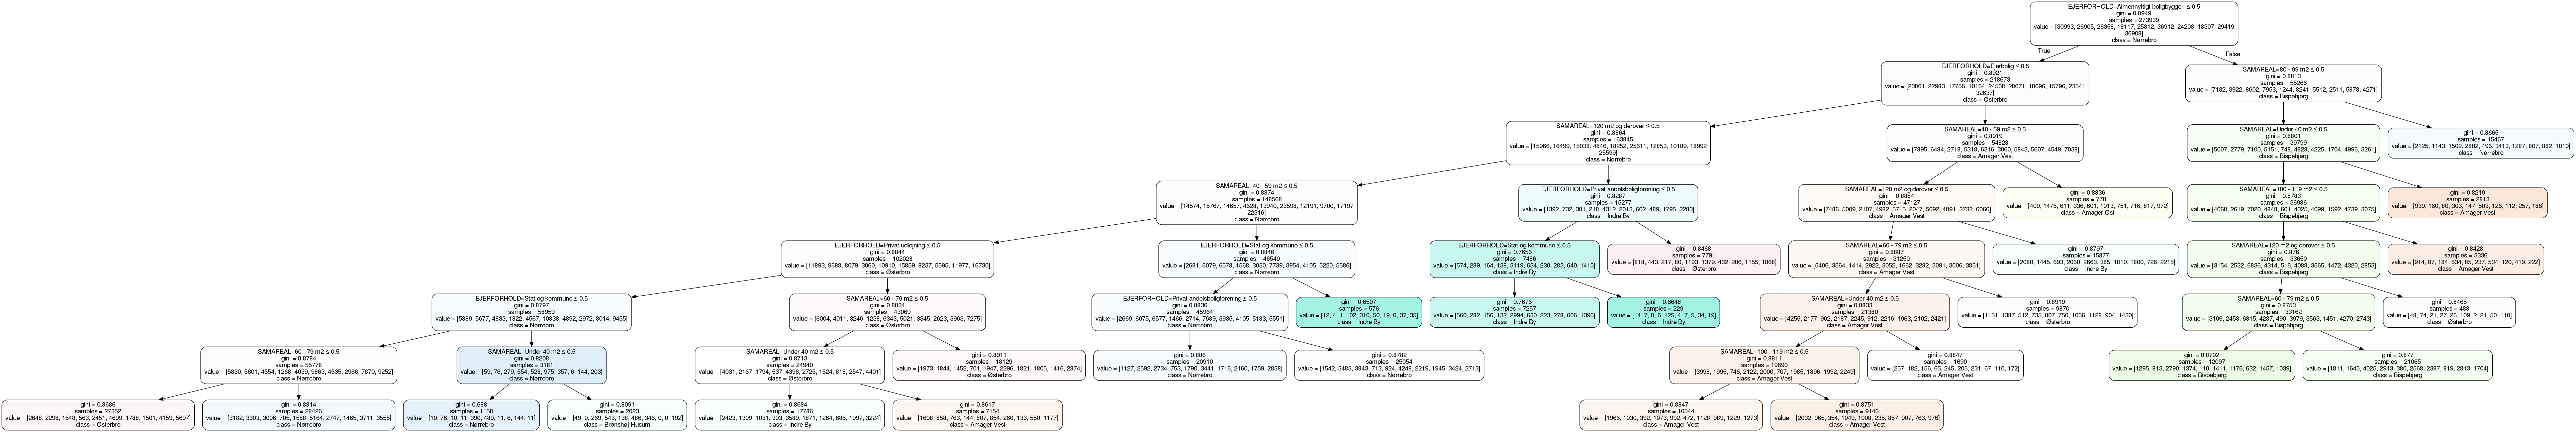

In [15]:
dot_data = StringIO()
tree.export_graphviz(ctf_bolig, out_file=dot_data,  
                         feature_names=vec1.get_feature_names(),  
                         class_names=ctf_bolig.classes_,  
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())

def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print "} else {"
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print "}"
                else:
                        print "return " + "[[" + ",".join(map(str,value[node][0])) + "]]" + ";"

        recurse(left, right, threshold, features, 0)
Image(graph.create_png())

In [16]:
get_code(ctf_civil, vec4.get_feature_names())

if ( Famtype=Ægtepar og reg. partnere <= 0.5 ) {
if ( Born=Familier uden børn <= 0.5 ) {
if ( Born=Familier med over 3 børn <= 0.5 ) {
if ( Famtype=Par samlevende og samboende <= 0.5 ) {
if ( Born=Familier med 3 børn <= 0.5 ) {
if ( Born=Familier med 1 barn <= 0.5 ) {
if ( Famtype=Enlig mand <= 0.5 ) {
return [[563.0,452.0,406.0,437.0,406.0,629.0,514.0,309.0,475.0,728.0]];
} else {
return [[56.0,42.0,53.0,52.0,48.0,51.0,46.0,40.0,53.0,63.0]];
}
} else {
if ( Famtype=Enlig kvinde <= 0.5 ) {
return [[260.0,238.0,211.0,203.0,244.0,254.0,224.0,162.0,264.0,297.0]];
} else {
return [[1167.0,963.0,930.0,766.0,882.0,1331.0,1073.0,700.0,1324.0,1502.0]];
}
}
} else {
if ( Famtype=Enlig mand <= 0.5 ) {
return [[130.0,70.0,130.0,143.0,51.0,166.0,113.0,55.0,89.0,131.0]];
} else {
return [[4.0,2.0,6.0,10.0,7.0,10.0,7.0,3.0,5.0,11.0]];
}
}
} else {
if ( Born=Familier med 1 barn <= 0.5 ) {
if ( Born=Familier med 3 børn <= 0.5 ) {
return [[615.0,451.0,259.0,331.0,435.0,609.0,433.0,348.0,620.0,616.0]];


## Discussion
We saw that there are many differences between the districts in Copenhagen.
There were some patterns that caracterized the different districts,
but none were defining enough for use in a machine learning model.

The overall data analysis went well as well as the construction of the machine learning models.
What did not go so well was finding good enough datasets for predicting what we wanted.

One possible explanation to why the features weren't defining could be that
all the different demographies live in each area of Copenhagen,
and living in a chosen area could be influenced by other factors such as personal taste for residence, necessity and random events
